In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

import wandb

import functools

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.family"] = "Times"
plt.rcParams["font.weight"] = "light"

%matplotlib inline

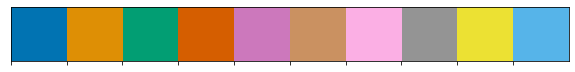

In [2]:
# establish and plot colorblind color pallete
colors = sns.color_palette('colorblind')
sns.palplot(colors)

# Weights and Biases API Work

In [3]:
api = wandb.Api(timeout=30)

@functools.lru_cache(maxsize=2048)
def extract_run_df(run, keys):
    keys_to_extract = keys
    set_keys_to_extract = set(keys)
    
    extracted_information = []
    for row in run.scan_history(list(keys)):
        extracted_row = {}
        if len(set(row.keys()).intersection(set_keys_to_extract)) > 1:
            for key in keys_to_extract:
                if key in row.keys():
                    extracted_row[key] = row[key]

            extracted_information.append(extracted_row)
    
    run_df = pd.DataFrame(extracted_information)
#     run_df = run_df.rename({"_step": "step"}, axis=1)
    
    return run_df

def filter_runs_by_tag(tag, all_runs):
    filtered_runs = [run for run in all_runs if tag in run.tags]
    return filtered_runs

# More Utils

In [4]:
cinic10_name_to_select_method_dict = {
    "uniform": "Uniform Sampling", 
    "_reducible_loss": "Reducible Loss (Ours)",
    "importance_sampling": "Gradient Norm IS",
    "_irreducible_loss": "Irreducible Loss", 
    "_gradnorm_ub": "Gradient Norm", 
    "_loss": "Loss",
}

selection_methods = ["Reducible Loss (Ours)", "Uniform Sampling", 
                     "Irreducible Loss", "Gradient Norm", "Loss", "SVP",  "Gradient Norm IS"]

selection_methods_color_dict = {
    "Reducible Loss (Ours)": colors[0], 
    "Reducible Loss (Ours)\nSmall Irrloss Model": colors[0], 
    "Uniform Sampling": colors[1], 
    "Irreducible Loss": colors[2],
    "Irreducible Loss\nSmall Irrloss Model": colors[2],
    "Gradient Norm": colors[3],
    "Loss": colors[4],
    "SVP": colors[5],
    "Gradient Norm IS": colors[6]
}

metrics_color_dict = {
    "Reducible Loss": colors[0], 
    "Gradient Norm": colors[3],
    "Loss": colors[4],
}

def str_to_selection_method_from_dict(string, name_dict):
    for k, v in name_dict.items():
        if k in string:
            return v
        
def run_to_selection_method(run):
    if run.config["logger/wandb/project"] == "svp_final":
        return "SVP"
    elif run.config["model/_target_"] == "src.models.ImportanceSamplingModel.ImportanceSamplingModel":
        return "Gradient Norm IS"
    else:
        name_dict  = {
            "src.curricula.selection_methods.uniform_selection": "Uniform Sampling", 
            "src.curricula.selection_methods.reducible_loss_selection": "Reducible Loss (Ours)", 
            "src.curricula.selection_methods.irreducible_loss_selection": "Irreducible Loss", 
            "src.curricula.selection_methods.gradnorm_ub_selection": "Gradient Norm", 
            "src.curricula.selection_methods.ce_loss_selection": "Loss"
        }
        return str_to_selection_method_from_dict(run.config["selection_method/_target_"], name_dict)
        
def df_to_xvals(df):
    return df["trainer/global_step"].to_numpy()

def compute_speedup(runs_all_info, baseline_name, ours_name):
    baseline_dfs = [d for _, c, d in runs_all_info if c == baseline_name]
    ours_dfs = [d for _, c, d in runs_all_info if c == ours_name]
            
    x_vals_baseline = df_to_xvals(baseline_dfs[0])
    y_vals_baseline = np.zeros(shape=(x_vals_baseline.size, len(baseline_dfs)))
    for sm_df_i, sm_df in enumerate(baseline_dfs):
        acc_baseline = 100*sm_df["val_acc_epoch"].to_numpy()
        y_vals_baseline[:acc_baseline.size, sm_df_i] = acc_baseline
    
    x_vals_ours = df_to_xvals(ours_dfs[0])
    y_vals_ours = np.zeros(shape=(x_vals_ours.size, len(ours_dfs)))
    for sm_df_i, sm_df in enumerate(ours_dfs):
        acc_ours = 100*sm_df["val_acc_epoch"].to_numpy()
        y_vals_ours[:acc_ours.size, sm_df_i] = acc_ours
    
    baseline_max = np.max(np.mean(y_vals_baseline, axis=-1))
    baseline_max_step = x_vals_baseline[np.argmax(np.mean(y_vals_baseline, axis=-1))]
    
    steps_outperformed = np.zeros(shape=len(ours_dfs))
    for run_i in range(len(ours_dfs)):
        nzs = np.nonzero(y_vals_ours[:, run_i] > baseline_max)[0]
        if len(nzs) > 0:
            indx = nzs[0]
            steps_outperformed[run_i] = x_vals_ours[indx]
        else:
            steps_outperformed[run_i] = np.inf
            
    return(np.mean(baseline_max_step)/np.mean(steps_outperformed))

def get_runs_by_tag_quick(project, tag):
#     api = wandb.Api(timeout=30)
    runs = api.runs(path=project, filters={"tags": tag})
    return list(runs)

In [5]:
def run_to_dataset(run):
    if "CINIC10" in run.config["datamodule"]:
        return "CINIC10"
    elif "CIFAR100" in run.config["datamodule"]:
        return "CIFAR100"
    elif "CIFAR10" in run.config["datamodule"]:
        return "CIFAR10"

# Figure 1a

In [ ]:
figure_1a_runs = [*filter_runs_by_tag("figure_1a", api.runs("goldiprox/cinic10")), 
                  *filter_runs_by_tag("figure_1a", api.runs("goldiprox/jb_cifar10")),
                  *filter_runs_by_tag("figure_1a", api.runs("goldiprox/cifar100"))]

In [ ]:
keys = ["trainer/global_step", "proportion_of_total_batch_loss_corresponding_to_the_top_20%_points_with_highest_reducible_loss_epoch", 
       "proportion_of_total_batch_loss_corresponding_to_the_top_20%_points_with_highest_loss_epoch",
       "proportion_of_total_batch_loss_corresponding_to_the_top_20%_points_with_highest_grad_norm_epoch"]

figure1a_all_info = list(zip(figure_1a_runs, 
                             [run_to_dataset(r) for r in figure_1a_runs], 
                             [extract_run_df(r, tuple(keys)) for r in figure_1a_runs]))# convert keys to tuple to allow LRU cache to be used

In [ ]:
fig = plt.figure(figsize=(5.75, 3), dpi=300)
datasets = ["CIFAR10", "CIFAR100", "CINIC10"]
dataset_xvals = [1, 3, 5]
bars = ["Reducible Loss", "Loss", "Gradient Norm"]
x_offset = [-0.5, 0, 0.5]

key_bar_dict = {
    "proportion_of_total_batch_loss_corresponding_to_the_top_20%_points_with_highest_reducible_loss_epoch": "Reducible Loss",
    "proportion_of_total_batch_loss_corresponding_to_the_top_20%_points_with_highest_loss_epoch": "Loss",
    "proportion_of_total_batch_loss_corresponding_to_the_top_20%_points_with_highest_grad_norm_epoch": "Gradient Norm"
}

n_max_miniepoch = 150


for run, dataset, run_df in figure1a_all_info:
    dataset_xval = dataset_xvals[datasets.index(dataset)]
    for k, v in key_bar_dict.items():
        val = run_df[k].to_numpy()[:n_max_miniepoch].mean()
        xshift = x_offset[bars.index(v)]
        label = v if dataset == "CIFAR10" else None
        
        plt.bar(dataset_xval+xshift, 100*val, 0.5, color=metrics_color_dict[v], label=label)

plt.plot([-5, 10], [20, 20], 'k--', linewidth=0.5)
plt.legend(fontsize=7, shadow=True, fancybox=True, loc="upper center", bbox_to_anchor=(.5, -0.25), title="Statistic", title_fontsize=8, ncol=2)
plt.ylabel("Proportion of total batch statistic\naccounted for by top 20% of points", fontsize=10)
plt.ylim([0, 100])
plt.xticks(dataset_xvals, datasets, fontsize=8)
plt.yticks(fontsize=8)
plt.xlim([0, 6])
plt.tight_layout()
plt.savefig("figure_outputs/figure_1a.pdf", bbox_inches="tight")

# Figure 1b

In [ ]:
keys = ["trainer/global_step", "selected_percentage_corrupted_epoch"]
figure_1b_runs = api.runs("goldiprox/label_noise_1b")
figure1b_all_info = list(zip(figure_1b_runs, [run_to_selection_method(r) for r in figure_1b_runs], 
                             [run_to_dataset(r) for r in figure_1b_runs],
                             [extract_run_df(r, tuple(keys)) for r in figure_1b_runs]))# convert keys to tuple to allow LRU cache to be used

figure_1b_small_runs = filter_runs_by_tag("figure_1b", api.runs("goldiprox/small_irrloss_final"))

In [ ]:
figure1b_all_info.extend(
    list(zip(figure_1b_small_runs, [f"{run_to_selection_method(r)}\nSmall Irrloss Model" for r in figure_1b_small_runs], 
                             [run_to_dataset(r) for r in figure_1b_small_runs],
                             [extract_run_df(r, tuple(keys)) for r in figure_1b_small_runs]))
)

In [ ]:
n_max_miniepoch = 150
fig = plt.figure(figsize=(5.25, 2.5), dpi=300)

datasets = ["CIFAR10", "CIFAR100", "CINIC10"]
dataset_xvals = [1, 3, 5]
selection_methods = ["Reducible Loss (Ours)", "Uniform Sampling", 
                     "Irreducible Loss", "Gradient Norm", "Loss",
                     "Reducible Loss (Ours)\nSmall Irrloss Model",
                    "Irreducible Loss\nSmall Irrloss Model"]
x_offset = [-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6]

for sm_i, sm in enumerate(selection_methods):
    for d_i, dataset in enumerate(datasets):
        sm_dfs = [df for _, sm_e, dataset_e, df in figure1b_all_info if sm_e == sm and dataset_e == dataset]
        dataset_xval = dataset_xvals[datasets.index(dataset)]
        if len(sm_dfs) > 0:
            xshift = x_offset[selection_methods.index(sm)]
            mean_corrupted = np.mean([sm_df["selected_percentage_corrupted_epoch"].to_numpy()[:n_max_miniepoch].mean() for sm_df in sm_dfs])
            label = sm if d_i == 0 else None
            plt.bar(dataset_xval+xshift, 100*mean_corrupted, color=selection_methods_color_dict[sm], width=0.2, label=label, 
                    hatch="///" if "Small" in sm else None, edgecolor="white")

plt.plot([-5, 10], [10, 10], 'k--', linewidth=0.5)
plt.legend(fontsize=7, shadow=True, fancybox=True, loc="upper left", 
           bbox_to_anchor=(1.01, 1.01), title="Selection Method", title_fontsize=8)
plt.ylabel("Proportion of selected points\nthat had label noise applied", fontsize=10)
plt.ylim([0, 30])
plt.xticks(dataset_xvals, datasets, fontsize=8)
plt.xlim([0, 6])
plt.tight_layout()
plt.savefig("figure_outputs/figure_1b.pdf", bbox_inches="tight")

# Figure 1 Combined

In [ ]:
plt.figure(figsize=(5.75, 2.5), dpi=300)
plt.subplot(121)
datasets = ["CIFAR10", "CIFAR100", "CINIC10"]
dataset_xvals = [1, 3, 5]
bars = ["Reducible Loss", "Loss", "Gradient Norm"]
x_offset = [-0.5, 0, 0.5]

key_bar_dict = {
    "proportion_of_total_batch_loss_corresponding_to_the_top_20%_points_with_highest_reducible_loss_epoch": "Reducible Loss",
    "proportion_of_total_batch_loss_corresponding_to_the_top_20%_points_with_highest_loss_epoch": "Loss",
    "proportion_of_total_batch_loss_corresponding_to_the_top_20%_points_with_highest_grad_norm_epoch": "Gradient Norm"
}

n_max_miniepoch = 150


for run, dataset, run_df in figure1a_all_info:
    dataset_xval = dataset_xvals[datasets.index(dataset)]
    for k, v in key_bar_dict.items():
        val = run_df[k].to_numpy()[:n_max_miniepoch].mean()
        xshift = x_offset[bars.index(v)]
        label = v if dataset == "CIFAR10" else None
        
        plt.bar(dataset_xval+xshift, 100*val, 0.5, color=metrics_color_dict[v], label=label)

plt.plot([-5, 10], [20, 20], 'k--', linewidth=0.5)
# plt.legend(fontsize=7, shadow=True, fancybox=True, loc="upper center", bbox_to_anchor=(.5, -0.25), title="Statistic", title_fontsize=8, ncol=2)
plt.ylabel("Proportion of total batch statistic\naccounted for by top 20% of points (%)", fontsize=10)
plt.ylim([0, 100])
plt.xticks(dataset_xvals, datasets, fontsize=8)
plt.yticks(fontsize=8)
plt.xlim([0, 6])

plt.subplot(122)
datasets = ["CIFAR10", "CIFAR100", "CINIC10"]
dataset_xvals = [1, 3, 5]
selection_methods = ["Reducible Loss (Ours)", "Uniform Sampling", 
                     "Irreducible Loss", "Gradient Norm", "Loss",
                     "Reducible Loss (Ours)\nSmall Irrloss Model",
                    "Irreducible Loss\nSmall Irrloss Model"]
x_offset = [-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6]

for sm_i, sm in enumerate(selection_methods):
    for d_i, dataset in enumerate(datasets):
        sm_dfs = [df for _, sm_e, dataset_e, df in figure1b_all_info if sm_e == sm and dataset_e == dataset]
        dataset_xval = dataset_xvals[datasets.index(dataset)]
        if len(sm_dfs) > 0:
            xshift = x_offset[selection_methods.index(sm)]
            mean_corrupted = np.mean([sm_df["selected_percentage_corrupted_epoch"].to_numpy()[:n_max_miniepoch].mean() for sm_df in sm_dfs])
            label = sm if d_i == 0 else None
            plt.bar(dataset_xval+xshift, 100*mean_corrupted, color=selection_methods_color_dict[sm], width=0.2, label=label, 
                    hatch="///" if "Small" in sm else None, edgecolor="white")

plt.plot([-5, 10], [10, 10], 'k--', linewidth=0.5)
plt.ylabel("Proportion of selected points\nthat had label noise applied (%)", fontsize=10)
plt.ylim([0, 30])
plt.xticks(dataset_xvals, datasets, fontsize=8)
plt.xlim([0, 6])
plt.tight_layout()
plt.legend(fontsize=8, shadow=True, fancybox=True, loc="upper center", 
           bbox_to_anchor=(-.25, -0.15), title="Selection Method", title_fontsize=10, ncol=4)
plt.savefig("figure_outputs/figure_1_combined_full.pdf", bbox_inches="tight")

# Figure 1 – compact version

In [ ]:
figure1b_all_info = list(zip(figure_1b_runs, [run_to_selection_method(r) for r in figure_1b_runs], 
                             [run_to_dataset(r) for r in figure_1b_runs],
                             [extract_run_df(r, tuple(keys)) for r in figure_1b_runs]))

In [ ]:
plt.figure(figsize=(5.75, 2.25), dpi=300)
plt.subplot(121)
datasets = ["CIFAR10", "CIFAR100", "CINIC10"]
dataset_xvals = [1, 3, 5]
bars = ["Reducible Loss", "Loss", "Gradient Norm"]
x_offset = [-0.5, 0, 0.5]

key_bar_dict = {
    "proportion_of_total_batch_loss_corresponding_to_the_top_20%_points_with_highest_reducible_loss_epoch": "Reducible Loss",
    "proportion_of_total_batch_loss_corresponding_to_the_top_20%_points_with_highest_loss_epoch": "Loss",
    "proportion_of_total_batch_loss_corresponding_to_the_top_20%_points_with_highest_grad_norm_epoch": "Gradient Norm"
}

n_max_miniepoch = 150


for run, dataset, run_df in figure1a_all_info:
    dataset_xval = dataset_xvals[datasets.index(dataset)]
    for k, v in key_bar_dict.items():
        val = run_df[k].to_numpy()[:n_max_miniepoch].mean()
        xshift = x_offset[bars.index(v)]
        label = v if dataset == "CIFAR10" else None
        
        plt.bar(dataset_xval+xshift, 100*val, 0.5, color=metrics_color_dict[v], label=label)

plt.plot([-5, 10], [20, 20], 'k--', linewidth=0.5)
# plt.legend(fontsize=7, shadow=True, fancybox=True, loc="upper center", bbox_to_anchor=(.5, -0.25), title="Statistic", title_fontsize=8, ncol=2)
plt.ylabel("Proportion of sum across batch\nfor which the top 20% of points\nare responsible (%)", fontsize=10)
plt.ylim([0, 100])
plt.xticks(dataset_xvals, datasets, fontsize=8)
plt.yticks(fontsize=8)
plt.xlim([0, 6])

plt.subplot(122)
datasets = ["CIFAR10", "CIFAR100", "CINIC10"]
dataset_xvals = [1, 3, 5]
selection_methods = ["Reducible Loss (Ours)", "Uniform Sampling", 
                     "Irreducible Loss", "Gradient Norm", "Loss",
                     "Reducible Loss (Ours)\nSmall Irrloss Model",
                    "Irreducible Loss\nSmall Irrloss Model"]
x_offset = [-0.6, -0.3, 0, 0.3, 0.6]

for sm_i, sm in enumerate(selection_methods):
    for d_i, dataset in enumerate(datasets):
        sm_dfs = [df for _, sm_e, dataset_e, df in figure1b_all_info if sm_e == sm and dataset_e == dataset]
        dataset_xval = dataset_xvals[datasets.index(dataset)]
        if len(sm_dfs) > 0:
            xshift = x_offset[selection_methods.index(sm)]
            mean_corrupted = np.mean([sm_df["selected_percentage_corrupted_epoch"].to_numpy()[:n_max_miniepoch].mean() for sm_df in sm_dfs])
            label = sm if d_i == 0 else None
            plt.bar(dataset_xval+xshift, 100*mean_corrupted, color=selection_methods_color_dict[sm], width=0.3, label=label, 
                    hatch="///" if "Small" in sm else None, edgecolor="white")

plt.plot([-5, 10], [10, 10], 'k--', linewidth=0.5)
plt.ylabel("Proportion of selected points\nthat had label noise applied (%)", fontsize=10)
plt.ylim([0, 40])
plt.xticks(dataset_xvals, datasets, fontsize=8)
plt.xlim([0, 6])
plt.tight_layout(pad=1.01)
plt.legend(fontsize=8, shadow=True, fancybox=True, loc="upper right", title="Selection Method", title_fontsize=10, ncol=1, bbox_to_anchor=(1.1, 1.15))
plt.savefig("figure_outputs/figure_1_combined_compact.pdf", bbox_inches="tight")

# Figure 2a

In [6]:
selection_methods = ["Reducible Loss (Ours)", "Uniform Sampling", 
                     "Irreducible Loss", "Gradient Norm", "Loss", "SVP",  "Gradient Norm IS"]

In [ ]:
keys = ["trainer/global_step", "val_acc_epoch"]

cifar10_runs_2a = [*filter_runs_by_tag("cifar10", api.runs("goldiprox/jb_cifar10")), *filter_runs_by_tag("cifar10", api.runs("goldiprox/svp_final"))]
cifar10_runs_all_info = list(zip(cifar10_runs_2a, [run_to_selection_method(r) for r in cifar10_runs_2a], [extract_run_df(r, tuple(keys)) for r in cifar10_runs_2a]))# convert keys to tuple to allow LRU cache to be used
print("cifar")
cinic10_runs_2a = [*filter_runs_by_tag("cinic10", api.runs("goldiprox/cinic10")), *filter_runs_by_tag("cinic10", api.runs("goldiprox/svp_final"))]
cinic10_runs_all_info = list(zip(cinic10_runs_2a, [run_to_selection_method(r) for r in cinic10_runs_2a], [extract_run_df(r, tuple(keys)) for r in cinic10_runs_2a]))# convert keys to tuple to allow LRU cache to be used
print("cinic")
cifar100_runs_2a = [*filter_runs_by_tag("cifar100", api.runs("goldiprox/cifar100")), *filter_runs_by_tag("cifar100", api.runs("goldiprox/svp_final"))]
cifar100_runs_all_info = list(zip(cifar100_runs_2a, [run_to_selection_method(r) for r in cifar100_runs_2a], [extract_run_df(r, tuple(keys)) for r in cifar100_runs_2a]))
print("cifar100")

In [7]:
keys = ["trainer/global_step", "val_acc_epoch"]
cifar10_runs_2a = [*filter_runs_by_tag("paper", api.runs("mtrazzak/clothing1m-samedist"))]
cifar10_runs_all_info = list(zip(cifar10_runs_2a, [run_to_selection_method(r) for r in cifar10_runs_2a], [extract_run_df(r, tuple(keys)) for r in cifar10_runs_2a]))# convert keys to tuple to allow LRU cache to be used
print("cifar")

cifar


In [8]:
compute_speedup(cifar10_runs_all_info, "Uniform Sampling", "Reducible Loss (Ours)")

3.4990912682734097

In [9]:
def figure2a_subplot(selection_methods, runs_all_info, ylim):
    for sm_i, sm in enumerate(selection_methods):
        sm_dfs = [d for _, c, d in runs_all_info if c == sm]
                
        if len(sm_dfs) == 0:
            print(f"Could not find any dfs corresponding to {sm}")
            continue
            
        x_vals = df_to_xvals(sm_dfs[0])
        y_vals = np.zeros(shape=(x_vals.size, len(sm_dfs)))

        for sm_df_i, sm_df in enumerate(sm_dfs):
            acc = 100*sm_df["val_acc_epoch"].to_numpy()
            y_vals[:acc.size, sm_df_i] = acc
        
        plt.plot(x_vals, np.mean(y_vals, axis=-1), color=selection_methods_color_dict[sm], linewidth=1, label=sm)
        plt.fill_between(x_vals, np.min(y_vals, axis=-1), np.max(y_vals, axis=-1), color=selection_methods_color_dict[sm], alpha=0.15, linewidth=0)
        plt.xlabel("Steps", fontsize=10)
        
        plt.ylabel("Test Accuracy (%)", fontsize=10)
        plt.xticks(fontsize=8)
        plt.yticks(fontsize=8)
        plt.ylim(ylim)
        plt.xlim([np.min(x_vals), np.max(x_vals)])
        
def figure2a_subplot_alt(selection_methods, runs_all_info, xlim):
    for sm_i, sm in enumerate(selection_methods):
        sm_dfs = [d for _, c, d in runs_all_info if c == sm]
        print(sm)
        if len(sm_dfs) == 0:
            print(f"Could not find any dfs corresponding to {sm}")
            continue
            
        x_vals = df_to_xvals(sm_dfs[0])
        acc_vals = np.zeros(shape=(x_vals.size, len(sm_dfs)))

        for sm_df_i, sm_df in enumerate(sm_dfs):
            acc_vals[:, sm_df_i] = 100*sm_df["val_acc_epoch"].to_numpy()
            
        xrange = np.linspace(xlim[0], xlim[1], 50)
        steps_needed = np.zeros((xrange.size, len(sm_dfs)))
                
        for i, acc in enumerate(xrange):
            for j in range(len(sm_dfs)):
                exceeded_acc = acc_vals[:, j] > acc
                if np.sum(exceeded_acc) > 0: # i.e., we exceeded the accuracy
                    steps_needed[i, j] = x_vals[np.nonzero(exceeded_acc)[0][0]]
                else:
                    steps_needed[i, j] = np.nan
                    
        plt.plot(xrange, np.mean(steps_needed, axis=-1), color=selection_methods_color_dict[sm], linewidth=1.5, label=sm)
        plt.fill_between(xrange, np.min(steps_needed, axis=-1), np.max(steps_needed, axis=-1), color=selection_methods_color_dict[sm], alpha=0.15, linewidth=0)
        plt.ylabel("Steps Required\nLower is Better", fontsize=10)
        
        plt.xlabel("Target Accuracy (%)", fontsize=10)
        plt.xticks(fontsize=8)
        plt.xlim(xlim)

In [ ]:
plt.figure(figsize=(5.75, 2), dpi=300)
plt.subplot(131)
figure2a_subplot(selection_methods, cifar10_runs_all_info, [0, 100])
plt.title("CIFAR10", fontsize=10)
print(compute_speedup(cifar10_runs_all_info, "Uniform Sampling", "Reducible Loss (Ours)"))
plt.subplot(132)
figure2a_subplot(selection_methods, cifar100_runs_all_info, [0, 70])
plt.title("CIFAR100", fontsize=10)
print(compute_speedup(cifar100_runs_all_info, "Uniform Sampling", "Reducible Loss (Ours)"))
plt.subplot(133)
figure2a_subplot(selection_methods, cinic10_runs_all_info, [10, 90])
plt.title("CINIC10", fontsize=10)
print(compute_speedup(cinic10_runs_all_info, "Uniform Sampling", "Reducible Loss (Ours)"))
plt.tight_layout()
plt.savefig("figure_outputs/figure2a_alt.pdf", bbox_inches='tight')
plt.legend(fancybox=True, shadow=True, fontsize=8, ncol=3, bbox_to_anchor=(-1, -0.35), loc="upper center")

# Figure 2a—alt

In [ ]:
plt.figure(figsize=(5.75, 2), dpi=300)
plt.subplot(131)
figure2a_subplot_alt(selection_methods, cifar10_runs_all_info, [0, 110])
plt.title("(a) CIFAR10", fontsize=10)
print(f"CIFAR10 speedup: {compute_speedup(cifar10_runs_all_info, 'Uniform Sampling', 'Reducible Loss (Ours)'):.2f}")
plt.subplot(132)
figure2a_subplot_alt(selection_methods, cifar100_runs_all_info, [0, 70])
plt.title("(b) CIFAR100", fontsize=10)
plt.ylabel(None)
print(f"CIFAR100 speedup: {compute_speedup(cifar100_runs_all_info, 'Uniform Sampling', 'Reducible Loss (Ours)'):.2f}")
plt.subplot(133)
figure2a_subplot_alt(selection_methods, cinic10_runs_all_info, [0, 90])
plt.title("(c) CINIC10", fontsize=10)
plt.ylabel(None)
plt.ylim([0, 20000])
print(f"CINIC10 speedup: {compute_speedup(cinic10_runs_all_info, 'Uniform Sampling', 'Reducible Loss (Ours)'):.2f}")

plt.tight_layout()
plt.legend(fancybox=True, shadow=True, fontsize=8, ncol=3, bbox_to_anchor=(-1, -0.35), loc="upper center")
plt.savefig("figure_outputs/figure_2a.pdf", bbox_inches='tight')

# Figure 2b

In [ ]:
cifar10_runs_2b = [*get_runs_by_tag_quick("goldiprox/jb_cifar10", "cifar10_labelnoise"), *get_runs_by_tag_quick("goldiprox/svp_final", "cifar10_labelnoise")]

In [ ]:
keys = ["trainer/global_step", "val_acc_epoch"]

# cifar10_runs_2b = [*filter_runs_by_tag("cifar10_labelnoise", api.runs("goldiprox/jb_cifar10")), *filter_runs_by_tag("cifar10_labelnoise", api.runs("goldiprox/svp_final"))]
cifar10_runs_2b = [*get_runs_by_tag_quick("goldiprox/jb_cifar10", "cifar10_labelnoise"), *get_runs_by_tag_quick("goldiprox/svp_final", "cifar10_labelnoise")]
cifar10_runs_all_info_2b = list(zip(cifar10_runs_2b, [run_to_selection_method(r) for r in cifar10_runs_2b], [extract_run_df(r, tuple(keys)) for r in cifar10_runs_2b]))# convert keys to tuple to allow LRU cache to be used
print("cifar10")
# cinic10_runs_2b = [*filter_runs_by_tag("cinic10_labelnoise", api.runs("goldiprox/cinic10")), *filter_runs_by_tag("cinic10_labelnoise", api.runs("goldiprox/svp_final"))]
cinic10_runs_2b = [*get_runs_by_tag_quick("goldiprox/cinic10", "cinic10_labelnoise"), *get_runs_by_tag_quick("goldiprox/svp_final", "cinic10_labelnoise")]
cinic10_runs_all_info_2b = list(zip(cinic10_runs_2b, [run_to_selection_method(r) for r in cinic10_runs_2b], [extract_run_df(r, tuple(keys)) for r in cinic10_runs_2b]))# convert keys to tuple to allow LRU cache to be used
print("cinic10")
cifar100_runs_2b = [*get_runs_by_tag_quick("goldiprox/cifar100", "cifar100_labelnoise"), *get_runs_by_tag_quick("goldiprox/svp_final", "cifar100_labelnoise")]
# cifar100_runs_2b = [*filter_runs_by_tag("cifar100_labelnoise", api.runs("goldiprox/cifar100")), *filter_runs_by_tag("cifar100_labelnoise", api.runs("goldiprox/svp_final"))]
cifar100_runs_all_info_2b = list(zip(cifar100_runs_2b, [run_to_selection_method(r) for r in cifar100_runs_2b], [extract_run_df(r, tuple(keys)) for r in cifar100_runs_2b]))
print("cifar10")

# Figure 2b – alt

In [ ]:
plt.figure(figsize=(5.75, 2), dpi=300)
plt.subplot(131)
figure2a_subplot_alt(selection_methods, cinic10_runs_all_info_2b, [0, 110])
plt.title("CIFAR10", fontsize=10)
print(f"CIFAR10 speedup: {compute_speedup(cifar10_runs_all_info_2b, 'Uniform Sampling', 'Reducible Loss (Ours)'):.2f}")
plt.subplot(132)
figure2a_subplot_alt(selection_methods, cifar100_runs_all_info_2b, [0, 70])
plt.title("CIFAR100", fontsize=10)
plt.ylabel(None)
print(f"CIFAR100 speedup: {compute_speedup(cifar100_runs_all_info_2b, 'Uniform Sampling', 'Reducible Loss (Ours)'):.2f}")
plt.subplot(133)
figure2a_subplot_alt(selection_methods, cinic10_runs_all_info_2b, [0, 90])
print(f"CINIC10 speedup: {compute_speedup(cinic10_runs_all_info_2b, 'Uniform Sampling', 'Reducible Loss (Ours)'):.2f}")
plt.title("CINIC10", fontsize=10)
plt.ylabel(None)
plt.tight_layout()
# plt.legend(fancybox=True, shadow=True, fontsize=8, ncol=3, bbox_to_anchor=(-1, -0.35), loc="upper center")
plt.savefig("figure_outputs/figure_2b.pdf", bbox_inches='tight')

# Figure 2 Combined

In [ ]:
plt.figure(figsize=(5.75, 3.75), dpi=300)
plt.subplot(231)
figure2a_subplot_alt(selection_methods, cifar10_runs_all_info, [0, 110])
plt.title("Half of CIFAR10", fontsize=10)
plt.xlabel(None)
print(f"CIFAR10 speedup: {compute_speedup(cifar10_runs_all_info, 'Uniform Sampling', 'Reducible Loss (Ours)'):.2f}")
plt.subplot(232)
figure2a_subplot_alt(selection_methods, cifar100_runs_all_info, [0, 70])
plt.title("Half of CIFAR100", fontsize=10)
plt.ylabel(None)
plt.xlabel(None)
print(f"CIFAR100 speedup: {compute_speedup(cifar100_runs_all_info, 'Uniform Sampling', 'Reducible Loss (Ours)'):.2f}")
splt = plt.subplot(233)
figure2a_subplot_alt(selection_methods, cinic10_runs_all_info, [0, 90])
plt.title("CINIC10", fontsize=10)
plt.ylabel(None)
plt.xlabel(None)
plt.ylim([0, 20000])
print(f"CINIC10 speedup: {compute_speedup(cinic10_runs_all_info, 'Uniform Sampling', 'Reducible Loss (Ours)'):.2f}")

plt.subplot(234)
figure2a_subplot_alt(selection_methods, cifar10_runs_all_info_2b, [0, 100])
plt.title("Half of CIFAR10\n(Label Noise)", fontsize=10)
print(f"CIFAR10 speedup: {compute_speedup(cifar10_runs_all_info_2b, 'Uniform Sampling', 'Reducible Loss (Ours)'):.2f}")
plt.subplot(235)
figure2a_subplot_alt(selection_methods, cifar100_runs_all_info_2b, [0, 70])
plt.title("Half of CIFAR100\n(Label Noise)", fontsize=10)
plt.ylabel(None)
print(f"CIFAR100 speedup: {compute_speedup(cifar100_runs_all_info_2b, 'Uniform Sampling', 'Reducible Loss (Ours)'):.2f}")
plt.subplot(236)
figure2a_subplot_alt(selection_methods, cinic10_runs_all_info_2b, [0, 90])
print(f"CINIC10 speedup: {compute_speedup(cinic10_runs_all_info_2b, 'Uniform Sampling', 'Reducible Loss (Ours)'):.2f}")
plt.title("CINIC10\n(Label Noise)", fontsize=10)
plt.ylabel(None)
plt.ylim([0, 20000])
plt.tight_layout()

splt.legend(fancybox=True, shadow=True, fontsize=8, ncol=3, bbox_to_anchor=(-1, -2.05), loc="upper center")
plt.savefig("figure_outputs/figure_2_combined.pdf", bbox_inches='tight')

# Clothing1M Figure

In [ ]:
keys = ["trainer/global_step", "val_acc_epoch"]

clothing_1m_runs = [*filter_runs_by_tag("paper", api.runs("mtrazzak/clothing1m-cleantrain"))]
clothing_1m_runs_all_info = list(zip(clothing_1m_runs, [run_to_selection_method(r) for r in clothing_1m_runs], [extract_run_df(r, tuple(keys)) for r in clothing_1m_runs]))# convert keys to tuple to allow LRU cache to be used

In [ ]:
all_runs_all_info_dict = {
    "clothing_1m_runs_all_info": clothing_1m_runs_all_info,
    "cinic10_runs_all_info": cinic10_runs_all_info,
    "cinic10_runs_all_info_2b": cinic10_runs_all_info_2b,
    "cifar10_runs_all_info": cifar10_runs_all_info,
    "cifar10_runs_all_info_2b": cifar10_runs_all_info_2b,
    "cifar100_runs_all_info": cifar100_runs_all_info,
    "cifar100_runs_all_info_2b": cifar100_runs_all_info_2b,
}

In [ ]:
import pickle

with open("all_runs_all_info_dict.pkl", "wb") as f:
    pickle.dump(all_runs_all_info_dict, f)

In [ ]:
compute_speedup(clothing_1m_runs_all_info, "Uniform Sampling", "Reducible Loss (Ours)")

In [ ]:
plt.figure(figsize=(3.5, 3.5), dpi=300)
figure2a_subplot_alt(selection_methods, clothing_1m_runs_all_info, [0, 100])
plt.title("Clothing-1M")
plt.legend(fontsize=8, loc="upper right")
plt.savefig("figure_outputs/clothing_1m.pdf", bbox_inches="tight")

# Figure 3 Combined

In [ ]:
from matplotlib.gridspec import GridSpec

In [ ]:
fig = plt.figure(figsize=(5.75, 2.75), dpi=300)
gs = GridSpec(2, 5, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
figure2a_subplot_alt(selection_methods, cifar10_runs_all_info, [0, 100])
plt.xlabel(None)
plt.ylabel(None)
plt.yticks([0, 10000], ["0", "10$^4$"], fontsize=6)
plt.xticks(fontsize=6)
plt.title("CIFAR10", fontsize=7)

ax2 = fig.add_subplot(gs[0, 1])
figure2a_subplot_alt(selection_methods, cifar100_runs_all_info, [0, 70])
plt.ylabel(None)
plt.xlabel(None)
plt.yticks([0, 10000], ["0", "10$^4$"], fontsize=6)
plt.xticks(fontsize=6)
plt.title("CIFAR10", fontsize=7)

ax3 = fig.add_subplot(gs[0, 2])
figure2a_subplot_alt(selection_methods, cinic10_runs_all_info, [0, 90])
plt.yticks([0, 20000], ["0", "2$\cdot$10$^4$"], fontsize=6)
plt.ylabel(None)
plt.xlabel(None)
plt.title("CIFAR10", fontsize=7)

ax4 = fig.add_subplot(gs[1, 0])
figure2a_subplot_alt(selection_methods, cifar10_runs_all_info_2b, [0, 100])
plt.xlabel(None)
plt.ylabel(None)
plt.yticks([0, 10000], ["0", "10$^4$"], fontsize=6)
plt.xticks(fontsize=6)
plt.title("CIFAR10", fontsize=7)
plt.xlabel("Target accuracy (%)", fontsize=7)

ax5 = fig.add_subplot(gs[1, 1])
figure2a_subplot_alt(selection_methods, cifar100_runs_all_info_2b, [0, 70])
plt.ylabel(None)
plt.xlabel(None)
plt.yticks([0, 10000], ["0", "10$^4$"], fontsize=6)
plt.xticks(fontsize=6)
plt.title("CIFAR10", fontsize=7)
plt.xlabel("Target accuracy (%)", fontsize=7)

ax6 = fig.add_subplot(gs[1, 2])
figure2a_subplot_alt(selection_methods, cinic10_runs_all_info_2b, [0, 90])
plt.yticks([0, 20000], ["0", "2$\cdot$10$^4$"], fontsize=6)
plt.xticks(fontsize=6)
plt.ylabel(None)
plt.xlabel(None)
plt.title("CIFAR10", fontsize=7)
plt.xlabel("Target accuracy (%)", fontsize=7)


ax7 = fig.add_subplot(gs[:, -2:])
figure2a_subplot_alt(selection_methods, clothing_1m_runs_all_info, [0, 100])
plt.plot([-10, -10], [0, 0], label="SVP", color=selection_methods_color_dict["SVP"])
plt.plot([-10, -10], [0, 0], label="Gradient Norm IS", color=selection_methods_color_dict["Gradient Norm IS"])
plt.yticks([0, 75000, 150000], ["0", "75$\cdot$10$^3$", "15$\cdot$10$^4$"], fontsize=8)
plt.title("Clothing-1M")
plt.legend(fontsize=8, loc="upper right", shadow=True, fancybox=True, bbox_to_anchor=(1.1, 1.1))
plt.ylabel(None)
plt.ylabel("Steps required to reach target accuracy")

plt.tight_layout()

# Figure 3 Combined V2

In [ ]:
sm

In [ ]:
fig = plt.figure(figsize=(5.75, 4.25), dpi=300)
gs = GridSpec(3, 4, figure=fig)
ax1 = fig.add_subplot(gs[0, 2])
figure2a_subplot_alt(selection_methods, cifar10_runs_all_info, [0, 100])
plt.xlabel(None)
plt.ylabel(None)
plt.yticks([0, 10000], ["0", "10$^4$"], fontsize=6)
plt.xticks(fontsize=6)
plt.title("CIFAR10", fontsize=8)
plt.ylabel("Steps required", fontsize=7)

ax2 = fig.add_subplot(gs[1, 2])
figure2a_subplot_alt(selection_methods, cifar100_runs_all_info, [0, 70])
plt.ylabel(None)
plt.xlabel(None)
plt.yticks([0, 10000], ["0", "10$^4$"], fontsize=6)
plt.xticks(fontsize=6)
plt.title("CIFAR100", fontsize=8)
plt.ylabel("Steps required", fontsize=7)

ax3 = fig.add_subplot(gs[2, 2])
figure2a_subplot_alt(selection_methods, cinic10_runs_all_info, [0, 90])
# plt.yticks([0, 20000], ["0", "2$\cdot$10$^4$"], fontsize=6)
plt.yticks([0, 10000], ["0", "10$^4$"], fontsize=6)
plt.xticks(fontsize=6)
plt.ylabel(None)
plt.xlabel(None)
plt.title("CINIC10", fontsize=8)
plt.xlabel("Target Accuracy (%)", fontsize=7)
plt.ylabel("Steps required", fontsize=7)

ax4 = fig.add_subplot(gs[0, 3])
figure2a_subplot_alt(selection_methods, cifar10_runs_all_info_2b, [0, 100])
plt.xlabel(None)
plt.ylabel(None)
plt.yticks([0, 10000], ["0", "10$^4$"], fontsize=6)
plt.xticks(fontsize=6)
plt.title("CIFAR10 (Label Noise)", fontsize=8)

ax5 = fig.add_subplot(gs[1, 3])
figure2a_subplot_alt(selection_methods, cifar100_runs_all_info_2b, [0, 70])
plt.ylabel(None)
plt.xlabel(None)
plt.yticks([0, 10000], ["0", "10$^4$"], fontsize=6)
plt.xticks(fontsize=6)
plt.title("CIFAR10 (Label Noise)", fontsize=8)

ax6 = fig.add_subplot(gs[2, 3])
figure2a_subplot_alt(selection_methods, cinic10_runs_all_info_2b, [0, 90])
plt.yticks([0, 10000], ["0", "10$^4$"], fontsize=6)
plt.xticks(fontsize=6)
plt.ylabel(None)
plt.xlabel(None)
plt.title("CINIC10 (Label Noise)", fontsize=8)
plt.xlabel("Target Accuracy (%)", fontsize=7)


ax7 = fig.add_subplot(gs[:-1, :2])
figure2a_subplot_alt(selection_methods, clothing_1m_runs_all_info, [0, 80])
plt.yticks([0, 75000, 150000], ["0", "75$\cdot$10$^3$", "15$\cdot$10$^4$"], fontsize=8)

plt.plot([-10, -10], [0, 0], label="SVP", color=selection_methods_color_dict["SVP"])
plt.plot([-10, -10], [0, 0], label="Gradient Norm IS", color=selection_methods_color_dict["Gradient Norm IS"])
plt.title("Clothing-1M")
plt.ylabel("Steps required to reach target accuracy")

plt.tight_layout()
plt.legend(fontsize=7, loc="upper center", bbox_to_anchor=(0.5, -0.225), shadow=True, fancybox=True, handlelength=0.75, 
           borderpad=0.5, handletextpad=0.5, ncol=2, title="Selection Method")
plt.savefig('figure_outputs/figure_3_large.pdf', bbox_inches='tight')

# Figure Relevance Experiment

In [ ]:
keys = ["trainer/global_step", "val_acc_epoch", "percentage_relevant_epoch"]

cinic10_relevance_runs = filter_runs_by_tag("cinic10_relevance", api.runs("goldiprox/cinic10_relevance"))
cinic10_relevance_all_info = list(zip(cinic10_relevance_runs, 
                             [run_to_selection_method(r) for r in cinic10_relevance_runs], 
                             [extract_run_df(r, tuple(keys)) for r in cinic10_relevance_runs]))# convert keys to tuple to allow LRU cache to be used

In [ ]:
keys = ["trainer\global_step", "val_acc_epoch", "percentage_relevant_epoch"]

In [ ]:
extract_run_df(cinic10_relevance_runs[-1], tuple(keys))

In [ ]:
cinic10_relevance_runs

In [ ]:
cinic10_relevance_all_info[0][0]

In [ ]:
plt.figure(figsize=(5.75, 2.25), dpi=300)
plt.subplot(121)
figure2a_subplot_alt(selection_methods, cinic10_relevance_all_info, [0, 100])

plt.subplot(122)
for sm_i, sm in enumerate(selection_methods):
    sm_dfs = [d for _, c, d in cinic10_relevance_all_info if c == sm]

    if len(sm_dfs) == 0:
        print(f"Could not find any dfs corresponding to {sm}")
        continue

    x_vals = df_to_xvals(sm_dfs[0])
   
    acc = 100*sm_dfs[0]["percentage_relevant_epoch"].to_numpy()
    acc_mask = ~np.isnan(acc)
    x_vals = x_vals[acc_mask]
    y_vals = np.zeros(shape=(x_vals.size, len(sm_dfs)))
    
    for sm_df_i, sm_df in enumerate(sm_dfs):
        acc = 100*sm_df["percentage_relevant_epoch"].to_numpy()
        acc_masked = acc[~np.isnan(acc)]
        y_vals[:acc_masked.size, sm_df_i] = acc_masked
    
    marker = "o" if sm == "Reducible Loss (Ours)" else None
        
    plt.plot(x_vals, np.median(y_vals, axis=-1), color=selection_methods_color_dict[sm], linewidth=1, label=sm, marker=marker, markevery=10, markersize=2)
    plt.fill_between(x_vals, np.min(y_vals, axis=-1), np.max(y_vals, axis=-1), color=selection_methods_color_dict[sm], alpha=0.15, linewidth=0)
    plt.xlabel("Steps", fontsize=10)

plt.ylabel("Percentage of selected\npoints relevant (%)", fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlim([np.min(x_vals), np.max(x_vals)])
plt.tight_layout()
plt.legend(ncol=3, loc="upper center", bbox_to_anchor=(-0.15, -0.25), shadow=True, fancybox=True)
print(f"CINIC10 speedup: {compute_speedup(cinic10_relevance_all_info, 'Uniform Sampling', 'Reducible Loss (Ours)'):.2f}")
plt.savefig("figure_outputs/figure_relevance.pdf", bbox_inches="tight")

# Figure Irred Loss Ablation

In [ ]:
tag_info_dict = {
        "uniform" : ("Uniform Sampling", ""),
        "resnet_4": ("Resnet-18", 0, "Epoch 4", colors[0]),
        "resnet_7": (None, 0.25, "Epoch 7", colors[0]),
        "best_loss_resnet": (None, 0.5, "Epoch 47 (Best Loss)", colors[0]),
        "resnet_best_acc": (None, 0.75, "Epoch 91 (Best Accuracy)", colors[0]),
        "small_cnn_6": ("Small CNN", 1.25, "Epoch 6", colors[1]),
        "small_cnn_16": (None, 1.5, "Epoch 16", colors[1]),
        "small_cnn_best_loss": (None, 1.75, "Epoch 38 (Best Loss)", colors[1]),
        "small_cnn_best_acc": (None, 2, "Epoch 86 (Best Accuracy)", colors[1]),
}

    
def get_info_from_run(run):    
    for k, v in tag_info_dict.items():
        if k in run.tags:
            return v
    
bars = []
    
    
keys = ["trainer/global_step", "val_acc_epoch"]

irred_loss_ablation_runs = filter_runs_by_tag("irred_loss_ablation", api.runs("goldiprox/jb_cifar10"))
irred_loss_ablation_all_info = list(zip(irred_loss_ablation_runs, 
                             [get_info_from_run(r) for r in irred_loss_ablation_runs], 
                             [extract_run_df(r, tuple(keys)) for r in irred_loss_ablation_runs]))

n_epochs = 100
baseline_dfs = [df for _, n, df in irred_loss_ablation_all_info if n[0] == "Uniform Sampling"]
uniform_acc_n_epochs = np.mean([df["val_acc_epoch"].to_numpy()[n_epochs-1] for df in baseline_dfs])

plt.figure(figsize=(2.7, 1.25), dpi=300)

ablations = list(tag_info_dict.values())[1:]
for a_i, ablation in enumerate(ablations):
    ablation_dfs = [df for _, n, df in irred_loss_ablation_all_info if n == ablation]
    ablation_infos = [n for _, n, df in irred_loss_ablation_all_info if n == ablation]
#     ablation_acc_vals = np.zeros(shape=(n_epochs, len(ablation_dfs)))
#     ablation_epochs_taken = np.zeros(shape=len(ablation_dfs))
    
#     for a_i_j, ablation_df in enumerate(ablation_dfs):
#         val_acc = ablation_df["val_acc_epoch"].to_numpy()
        
#         nzs = np.nonzero(val_acc > uniform_acc_n_epochs)[0]
#         if len(nzs > 0):
#             epoch_taken = nzs[0]
#         else:
#             epoch_taken = np.nan
        
        
#         if val_acc.size > n_epochs:
#             ablation_acc_vals[:, a_i_j] = val_acc[:n_epochs]
            
#         ablation_epochs_taken[a_i_j] = epoch_taken
    
    y_val = ablation_infos[0][1]
    speedup = compute_speedup(irred_loss_ablation_all_info, ("Uniform Sampling", ""), ablation)
    plt.xlim([0, 5])
    plt.barh(y_val, speedup, height=0.25, color=ablation_infos[0][3], edgecolor="k", linewidth=1, label=ablation_infos[0][0])
    if np.isnan(np.mean(ablation_epochs_taken)):
        plt.text(0.01, y_val, "$\infty$", ha='left', va='center')
    
    
ytick_vals = [i[1] for k, i in list(tag_info_dict.items())[1:]]
ytick_labels = [i[2] for k, i in list(tag_info_dict.items())[1:]]
plt.yticks(ytick_vals, ytick_labels, fontsize=8)
plt.xlabel("Speedup")
plt.legend(loc="upper right", fontsize=7, fancybox=True, shadow=True, bbox_to_anchor=(1.01, 1.05))
plt.title("CIFAR10 Irreducible Loss\nModel Ablation", fontsize=10)
plt.savefig("figure_outputs/irreducible_loss_model_ablation.pdf", bbox_inches='tight')

# Figure Full Ablation

In [ ]:
keys = ["trainer/global_step", "val_acc_epoch"]

cifar100_ablation_runs = [*filter_runs_by_tag("cifar100_ablation", api.runs("goldiprox/cifar100")), 
                          *filter_runs_by_tag("cifar100_ablation", api.runs("goldiprox/cifar_update_irreducible"))]

cifar100_runs_all_info = list(zip(cifar100_ablation_runs, [run_to_selection_method(r) for r in cifar100_ablation_runs], [extract_run_df(r, tuple(keys)) for r in cifar100_ablation_runs]))

cifar10_ablation_runs = filter_runs_by_tag("cifar10_ablation", api.runs("goldiprox/jb_cifar10"))
cifar10_runs_all_info = list(zip(cifar10_ablation_runs, [run_to_selection_method(r) for r in cifar10_ablation_runs], [extract_run_df(r, tuple(keys)) for r in cifar10_ablation_runs]))


cinic10_ablation_runs = filter_runs_by_tag("cinic10_ablation", api.runs("goldiprox/goldiprox"))
cinic10_runs_all_info = list(zip(cinic10_ablation_runs, [run_to_selection_method(r) for r in cinic10_ablation_runs], [extract_run_df(r, tuple(keys)) for r in cinic10_ablation_runs]))

In [ ]:
ablations = {
    'Reducible Loss (Ours) 0.05': {
        'baseline': 'Uniform Sampling 0.05',
        "label": "5%",
        "color": colors[0],
    },
    'Reducible Loss (Ours) 0.1': {
        'baseline': 'Uniform Sampling 0.1',
        "label" : "10%",
        "color": colors[1],
    },
    'Reducible Loss (Ours) 0.15': {
        'baseline': 'Uniform Sampling 0.15',
        "label" : "15%",
        "color": colors[2],
    },
    'Reducible Loss (Ours) 0.2': {
        'baseline': 'Uniform Sampling 0.2',
        "label" : "20%",
        "color": colors[3],
    }
}

plt.figure(figsize=(2.75, 1.25), dpi=300)

datasets = [cifar100_runs_all_info, cifar10_runs_all_info, cinic10_runs_all_info]
dataset_names = ["CIFAR100", "CIFAR10", "CINIC10"]
for d_i, dataset in enumerate(datasets):
    for ab_i, (ab, ab_dict) in enumerate(ablations.items()):
        if d_i == 2:
            speedup = compute_speedup_legacy(dataset, "Uniform Sampling 0.1", ab)
        else:
            speedup = compute_speedup_legacy(dataset, ab_dict["baseline"], ab)
            
        plt.barh(d_i+(1+ab_i)*1.0/(1+len(ablations.keys())), speedup, 1.0/(1+len(ablations.keys())), 
                 label=ab_dict["label"] if d_i==0 else None, color=ab_dict["color"]) 
plt.yticks([0.5, 1.5, 2.5], dataset_names)
plt.legend(fontsize=7, ncol=2, title="Percentage Selected", title_fontsize=9)
plt.xlabel("Speedup", fontsize=8)
plt.savefig("figure_outputs/figure_percent_selected.pdf", bbox_inches="tight")